## Refine B cell annotations for large intestine - relabelling uncertain cells based on majority voting

In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import sys
import os
from collections import Counter

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import to_hex
import ast

In [2]:
sc.logging.print_header()

scanpy==1.8.0 anndata==0.8.0 umap==0.4.6 numpy==1.20.1 scipy==1.6.1 pandas==1.3.5 scikit-learn==0.24.1 statsmodels==0.13.5 python-igraph==0.8.3 louvain==0.7.0 leidenalg==0.8.3 pynndescent==0.5.2


In [3]:
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

In [4]:
sc.set_figure_params(
    dpi=200,dpi_save=300,
    fontsize=12,
    frameon=False,
    transparent=True,
)

In [5]:
sns.set_style(style="white")
sns.set_context(context="paper")

In [6]:
adata = sc.read_h5ad('/nfs/team205/ao15/Megagut/Annotations_v3/h5ad/disease/compartments/Bcells_pooled_disease.gene_cellbender.good_qc_cluster_mito80.stringent_doublet_removed.hvg7500_noCC.scvi_output.lv20_batch256.with_raw_counts.scArches_broad_pred.20230124.h5ad')

In [7]:
adata

AnnData object with n_obs × n_vars = 106472 × 36601
    obs: 'latent_cell_probability', 'latent_RT_efficiency', 'cecilia22_predH', 'cecilia22_predH_prob', 'cecilia22_predH_uncertain', 'cecilia22_predL', 'cecilia22_predL_prob', 'cecilia22_predL_uncertain', 'elmentaite21_pred', 'elmentaite21_pred_prob', 'elmentaite21_pred_uncertain', 'suo22_pred', 'suo22_pred_prob', 'suo22_pred_uncertain', 'n_counts', 'log1p_n_counts', 'n_genes', 'log1p_n_genes', 'percent_mito', 'n_counts_mito', 'percent_ribo', 'n_counts_ribo', 'percent_hb', 'n_counts_hb', 'percent_top50', 'n_counts_raw', 'log1p_n_counts_raw', 'n_genes_raw', 'log1p_n_genes_raw', 'percent_mito_raw', 'n_counts_mito_raw', 'percent_ribo_raw', 'n_counts_ribo_raw', 'percent_hb_raw', 'n_counts_hb_raw', 'percent_top50_raw', 'n_counts_spliced', 'log1p_n_counts_spliced', 'n_genes_spliced', 'log1p_n_genes_spliced', 'percent_mito_spliced', 'n_counts_mito_spliced', 'percent_ribo_spliced', 'n_counts_ribo_spliced', 'percent_hb_spliced', 'n_counts_hb_sp

In [8]:
adata_scanvi = pd.read_csv('/nfs/team205/ao15/Megagut/Annotations_v3/metadata/X_scANVI/disease/disease_fine_annot_predict_B_20230226.csv.gz',compression='gzip',index_col=0)

In [9]:
adata_scanvi

LV1       LV2       LV3       LV4  \
index                                                                      
AAACCTGAGAGGTTAT-4918STDY7273964 -0.182853 -0.055051  0.129861  0.010175   
AAACGGGAGAGCTGGT-4918STDY7273964  0.032228 -0.127286  0.088927  0.096875   
AAACGGGCACTAAGTC-4918STDY7273964  0.165797  0.025699  0.026137  0.075255   
AAACGGGGTAAAGGAG-4918STDY7273964 -0.428445  0.874057 -0.080057  0.509662   
AAACGGGGTAGCGATG-4918STDY7273964 -0.110093 -0.326858  0.090055  0.050834   
...                                    ...       ...       ...       ...   
TTTGCGCGTCTGATTG-GSM4546346       0.000742  0.048535  0.045700  0.035928   
TTTGCGCTCATTGCCC-GSM4546346       1.150696  0.047837 -0.210524  0.126120   
TTTGGTTGTACCTACA-GSM4546346      -0.216642  1.216335 -0.028942  0.059733   
TTTGTCATCGGAAACG-GSM4546346       1.315174  0.177124 -0.090409 -0.089336   
TTTGTCATCGGATGTT-GSM4546346       0.669131  0.837786  0.047532 -0.014530   

                                       LV5       LV6       LV7       LV8  \
index                                                                      
AAACCTGAGAGGTTAT-4918STDY7273964 -0.358423  0.012688 -0.329064  0.552721   
AAACGGGAGAGCTGGT-4918STDY7273964  0.104098 -0.001083 -0.413132  0.336256   
AAACGGGCACTAAGTC-4918STDY7273964 -0.259465 -0.026657 -0.135315  0.845352   
AAACGGGGTAAAGGAG-4918STDY7273964  0.086164  0.104386  0.018512 -1.429693   
AAACGGGGTAGCGATG-4918STDY7273964 -0.329513  0.043639 -0.046950  0.507594   
...                                    ...       ...       ...       ...   
TTTGCGCGTCTGATTG-GSM4546346      -0.440970  0.038812  0.507420 -0.185946   
TTTGCGCTCATTGCCC-GSM4546346      -0.050555  0.101302  0.239386  0.139913   
TTTGGTTGTACCTACA-GSM4546346      -0.319058  0.141362  0.232176 -0.251235   
TTTGTCATCGGAAACG-GSM4546346       0.930435 -0.016122 -0.583938  0.090798   
TTTGTCATCGGATGTT-GSM4546346      -0.319860  0.093311  0.203366 -0.059503   

                                       LV9      LV10      LV11      LV12  \
index                                                                      
AAACCTGAGAGGTTAT-4918STDY7273964 -0.219694  0.421622 -0.146920 -0.109510   
AAACGGGAGAGCTGGT-4918STDY7273964 -0.137968  0.378295 -0.130219 -0.096623   
AAACGGGCACTAAGTC-4918STDY7273964  0.000211  0.122731 -0.128680 -0.094996   
AAACGGGGTAAAGGAG-4918STDY7273964 -0.099613  0.137998 -0.154342 -0.098822   
AAACGGGGTAGCGATG-4918STDY7273964  0.047527  0.189970 -0.095063 -0.107143   
...                                    ...       ...       ...       ...   
TTTGCGCGTCTGATTG-GSM4546346      -0.639484 -0.004300 -0.058265 -0.107927   
TTTGCGCTCATTGCCC-GSM4546346      -0.462801 -0.165851  0.093769 -0.085959   
TTTGGTTGTACCTACA-GSM4546346       1.707904  0.287929 -0.042562 -0.128562   
TTTGTCATCGGAAACG-GSM4546346      -0.823490  0.169515  0.097408 -0.137324   
TTTGTCATCGGATGTT-GSM4546346       1.670230  0.196890 -0.080393 -0.149962   

                                      LV13      LV14      LV15      LV16  \
index                                                                      
AAACCTGAGAGGTTAT-4918STDY7273964 -0.119088 -0.071079 -0.039918  0.306495   
AAACGGGAGAGCTGGT-4918STDY7273964 -0.307476 -0.075311 -0.077002  0.284345   
AAACGGGCACTAAGTC-4918STDY7273964 -0.302314 -0.033069 -0.096825 -0.229130   
AAACGGGGTAAAGGAG-4918STDY7273964  0.202240 -0.041588  0.063394 -0.774859   
AAACGGGGTAGCGATG-4918STDY7273964 -0.154675 -0.017247 -0.068661  0.066715   
...                                    ...       ...       ...       ...   
TTTGCGCGTCTGATTG-GSM4546346      -0.343886  0.025337 -0.057391  0.865286   
TTTGCGCTCATTGCCC-GSM4546346      -0.291848  0.034110 -0.047429  0.971700   
TTTGGTTGTACCTACA-GSM4546346       0.571779  0.074669 -0.110403 -1.657449   
TTTGTCATCGGAAACG-GSM4546346       0.119259 -0.047766 -0.048340 -1.231172   
TTTGTCATCGGATGTT-GSM4546346      -0.112647  0.063541 -0.193445 -2.181961   

                                      LV17      LV18      LV19      LV20  
index   

In [10]:
adata.obsm['X_scANVI'] = adata_scanvi

In [11]:
adata_meta = pd.read_csv('/nfs/team205/ao15/Megagut/Annotations_v3/metadata/disease/20230308/scanvi/disease_fine_annot_predict_B_20230226.csv',index_col=0)

/home/jovyan/my-conda-envs/standard_plotting/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3437: DtypeWarning: Columns (73,82,83,84,86,93,100) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [12]:
adata_meta

latent_cell_probability  \
index                                                       
AAACCTGAGAGGTTAT-4918STDY7273964                 0.999636   
AAACGGGAGAGCTGGT-4918STDY7273964                 0.999145   
AAACGGGCACTAAGTC-4918STDY7273964                 0.999503   
AAACGGGGTAAAGGAG-4918STDY7273964                 0.999479   
AAACGGGGTAGCGATG-4918STDY7273964                 0.999532   
...                                                   ...   
TTTGCGCGTCTGATTG-GSM4546346                      0.999901   
TTTGCGCTCATTGCCC-GSM4546346                      0.999707   
TTTGGTTGTACCTACA-GSM4546346                      0.999942   
TTTGTCATCGGAAACG-GSM4546346                      0.999914   
TTTGTCATCGGATGTT-GSM4546346                      0.999864   

                                  latent_RT_efficiency cecilia22_predH  \
index                                                                    
AAACCTGAGAGGTTAT-4918STDY7273964              1.277868         B cells   
AAACGGGAGAGCTGGT-4918STDY7273964              1.139521         B cells   
AAACGGGCACTAAGTC-4918STDY7273964              1.281189         B cells   
AAACGGGGTAAAGGAG-4918STDY7273964              0.905393         B cells   
AAACGGGGTAGCGATG-4918STDY7273964              1.190154         B cells   
...                                                ...             ...   
TTTGCGCGTCTGATTG-GSM4546346                   1.726214    Plasma cells   
TTTGCGCTCATTGCCC-GSM4546346                   1.031985    Plasma cells   
TTTGGTTGTACCTACA-GSM4546346                   2.202289    Plasma cells   
TTTGTCATCGGAAACG-GSM4546346                   1.798503    Plasma cells   
TTTGTCATCGGATGTT-GSM4546346                   1.511129    Plasma cells   

                                  cecilia22_predH_prob  \
index                                                    
AAACCTGAGAGGTTAT-4918STDY7273964              0.999935   
AAACGGGAGAGCTGGT-4918STDY7273964              0.999925   
AAACGGGCACTAAGTC-4918STDY7273964              0.999567   
AAACGGGGTAAAGGAG-4918STDY7273964              0.991974   
AAACGGGGTAGCGATG-4918STDY7273964              0.999998   
...                                                ...   
TTTGCGCGTCTGATTG-GSM4546346                   0.999993   
TTTGCGCTCATTGCCC-GSM4546346                   0.999940   
TTTGGTTGTACCTACA-GSM4546346                   0.999890   
TTTGTCATCGGAAACG-GSM4546346                   0.999448   
TTTGTCATCGGATGTT-GSM4546346                   0.998636   

                                 cecilia22_predH_uncertain  \
index                                                        
AAACCTGAGAGGTTAT-4918STDY7273964                   B cells   
AAACGGGAGAGCTGGT-4918STDY7273964                   B cells   
AAACGGGCACTAAGTC-4918STDY7273964                   B cells   
AAACGGGGTAAAGGAG-4918STDY7273964                   B cells   
AAACGGGGTAGCGATG-4918STDY7273964                   B cells   
...                                                    ...   
TTTGCGCGTCTGATTG-GSM4546346                   Plasma cells   
TTTGCGCTCATTGCCC-GSM4546346                   Plasma cells   
TTTGGTTGTACCTACA-GSM4546346                   Plasma cells   
TTTGTCATCGGAAACG-GSM4546346                   Plasma cells   
TTTGTCATCGGATGTT-GSM4546346                   Plasma cells   

                                          cecilia22_predL  \
index                                                       
AAACCTGAGAGGTTAT-4918STDY7273964            Naive B cells   
AAACGGGAGAGCTGGT-4918STDY7273964            Naive B cells   
AAACGGGCACTAAGTC-4918STDY7273964            Naive B cells   
AAACGGGGTAAAGGAG-4918STDY7273964  Germinal center B cells   
AAACGGGGTAGCGATG-4918STDY7273964            Naive B cells   
...                                                   ...   
TTTGCGCGTCTGATTG-GSM4546346                  Plasma cells   
TTTGCGCTCATTGCCC-GSM4546346                  Plasma cells   
TTTGGTTGTACCTACA-GSM4546346                  Plasma cells   
TTTGTCATCGGAAACG-GSM4546346                 

In [13]:
adata.obs = adata_meta

In [14]:
sc.pp.neighbors(adata, use_rep="X_scANVI")
sc.tl.umap(adata)

/home/jovyan/my-conda-envs/standard_plotting/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


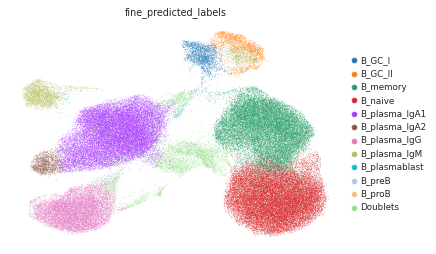

In [15]:
sc.pl.umap(adata, color=['fine_predicted_labels'])

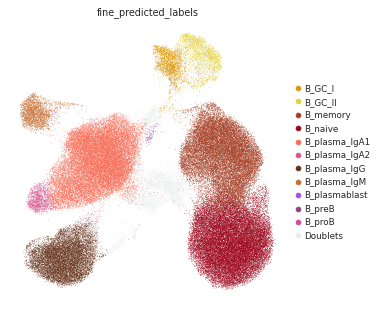

In [16]:
plt.rcParams['figure.figsize'] = [5,5]
sc.pl.umap(adata,color='fine_predicted_labels',palette = ['#db9602', #B_GC_I
'#e2d138', #B_GC_II
'#a33c22',#B_memory
'#9b0319', #B_naive
'#f76c56',#B_plasma_IgA1
'#d6558d',#B_plasma_IgA2
'#632f17',#B_plasma_IgG                            
'#c66d31',#B_plasma_IgM
'#9e53db',#B_plasmablast
'#8a4682',#B_preB
'#d34794',#pro b
                                                            '#ebeded',#doublets
                                                          
                                                         ],size=1.5,save='B_scanviannot_predicted_labels.pdf')

In [17]:
adata.X.max()

46501.0

In [18]:
adata.layers['counts'] = adata.X

In [19]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

In [20]:
marker_genes_dict = {'General B cell markers':['CD79A','CD79B','CD19','HLA-DRA','HLA-DRB1','MS4A1'],
                     'Germinal centre B cells':['MKI67','AICDA','BCL6','SUGCT'],
                    'Memory B cells':['CD27','TNFRSF13B'],
                     'Naive B cells':['SELL','TCL1A','IGHD'],
                     'General Plasma cell markers':['MZB1','XBP1'],
                     'IgA plasma cells':['IGHA1','IGHA2'],
                     'IgG plasma cells':['IGHG3','IGHG1','IGHG2','IGHG4'],
                     'IgM plasma cells':['IGHM'],
                     'Pre/proB cells':['SPIB','CD37','IGLL1','RAG1','DNTT','VPREB3']}

In [21]:
adata

AnnData object with n_obs × n_vars = 106472 × 36601
    obs: 'latent_cell_probability', 'latent_RT_efficiency', 'cecilia22_predH', 'cecilia22_predH_prob', 'cecilia22_predH_uncertain', 'cecilia22_predL', 'cecilia22_predL_prob', 'cecilia22_predL_uncertain', 'elmentaite21_pred', 'elmentaite21_pred_prob', 'elmentaite21_pred_uncertain', 'suo22_pred', 'suo22_pred_prob', 'suo22_pred_uncertain', 'n_counts', 'log1p_n_counts', 'n_genes', 'log1p_n_genes', 'percent_mito', 'n_counts_mito', 'percent_ribo', 'n_counts_ribo', 'percent_hb', 'n_counts_hb', 'percent_top50', 'n_counts_raw', 'log1p_n_counts_raw', 'n_genes_raw', 'log1p_n_genes_raw', 'percent_mito_raw', 'n_counts_mito_raw', 'percent_ribo_raw', 'n_counts_ribo_raw', 'percent_hb_raw', 'n_counts_hb_raw', 'percent_top50_raw', 'n_counts_spliced', 'log1p_n_counts_spliced', 'n_genes_spliced', 'log1p_n_genes_spliced', 'percent_mito_spliced', 'n_counts_mito_spliced', 'percent_ribo_spliced', 'n_counts_ribo_spliced', 'percent_hb_spliced', 'n_counts_hb_sp

/home/jovyan/my-conda-envs/standard_plotting/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


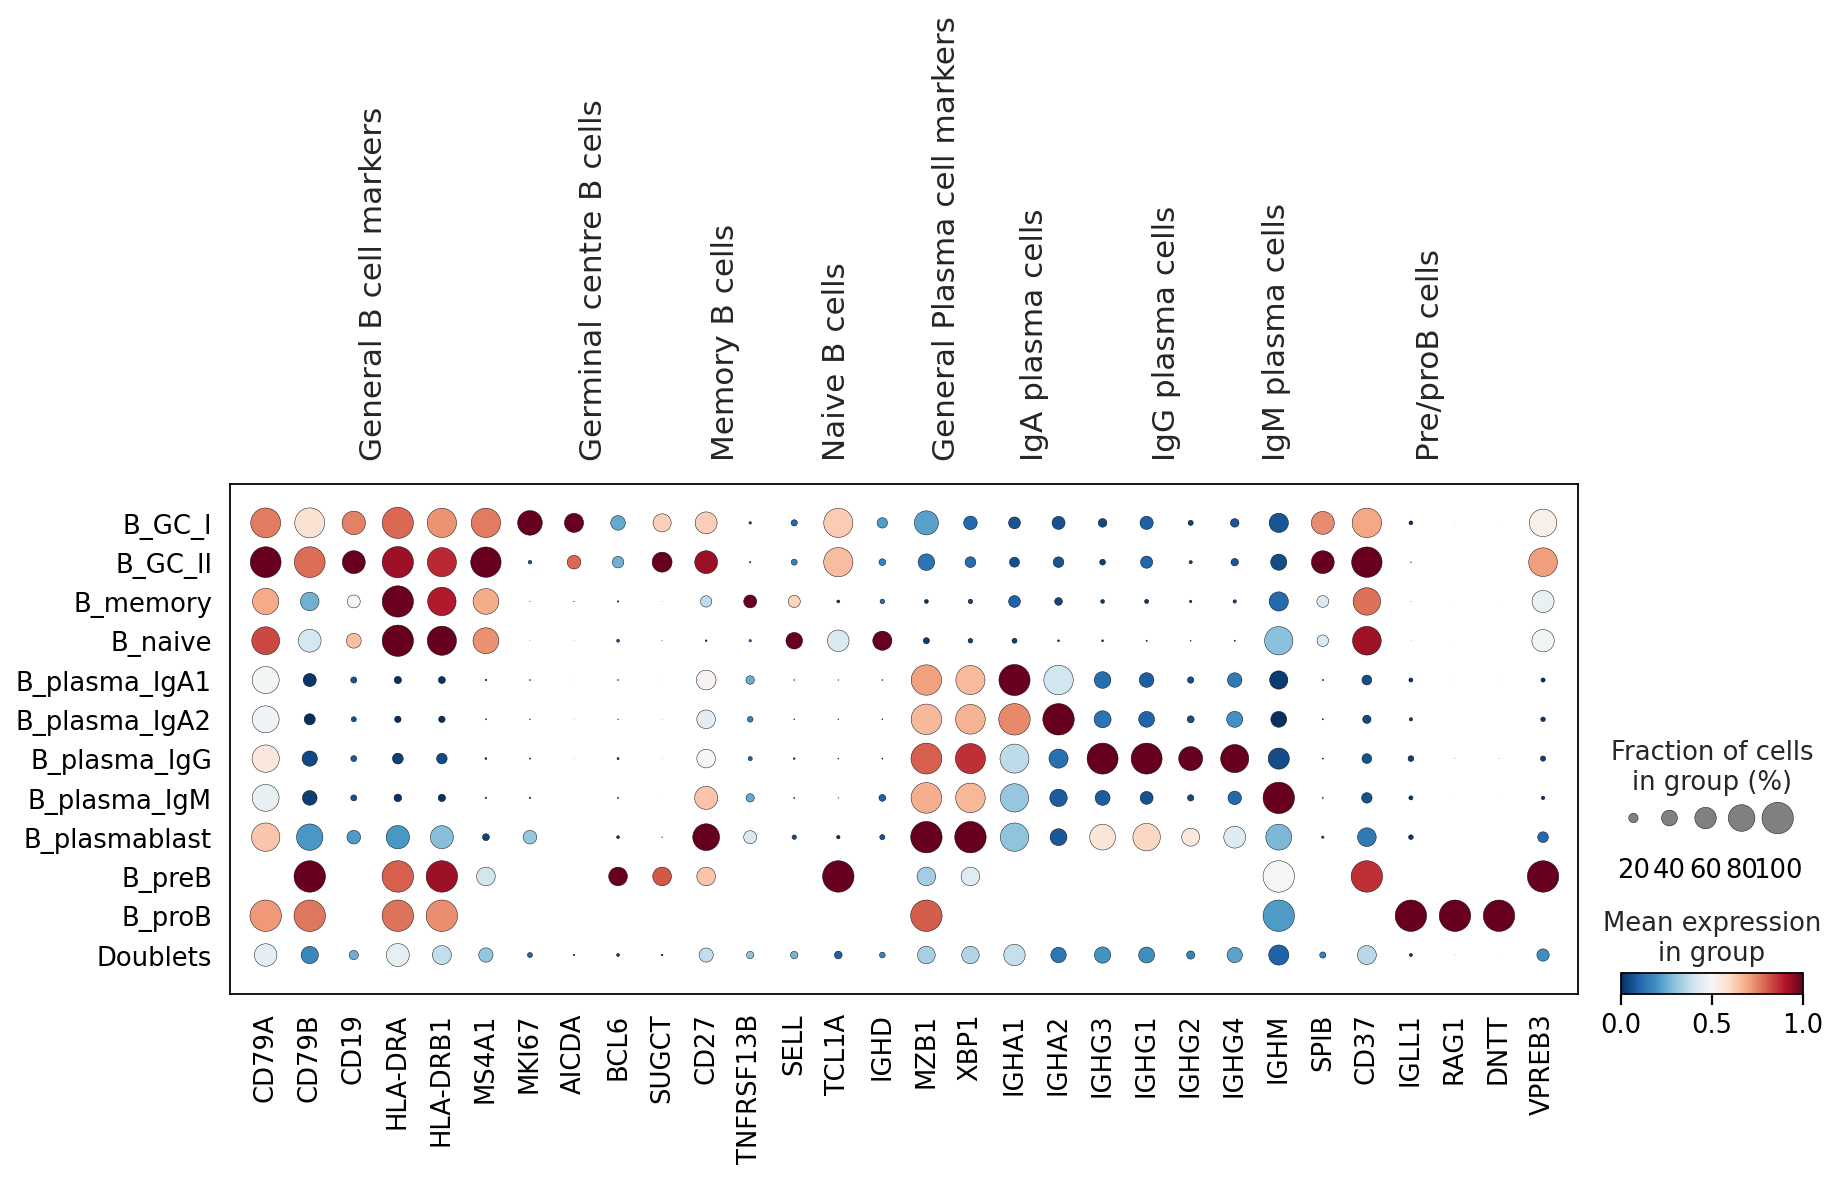

In [22]:
sc.set_figure_params(dpi_save = 300)
sc.pl.dotplot(adata,var_names=marker_genes_dict,groupby='fine_predicted_labels',color_map='RdBu_r', standard_scale='var',save='b_scanviannot_marker_gene_dotplot.pdf')

In [23]:
uncert = adata.obs[['fine_predicted_labels','fine_predicted_labels_uncertainty']] 

In [24]:
#calculate 90th percentile to use as cut off for uncertain cells
p = np.percentile(adata.obs['fine_predicted_labels_uncertainty'], 90) # return 90th percentile
print(p)

0.37998234629631045


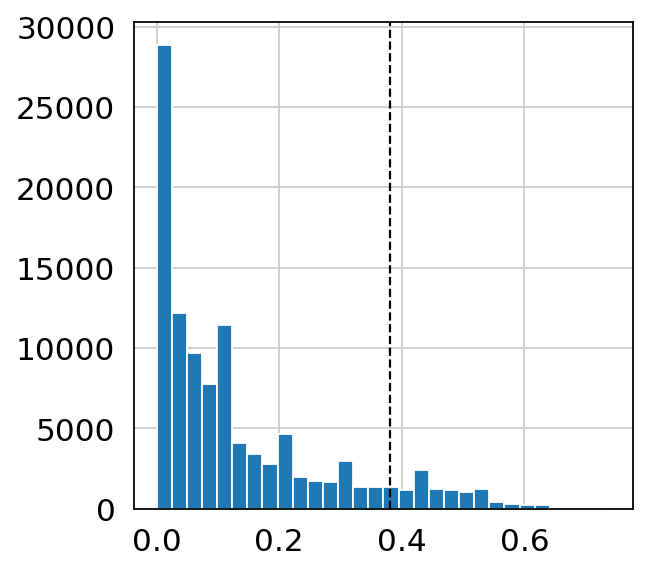

In [25]:
#plot uncertainty distribution
plt.hist(adata.obs['fine_predicted_labels_uncertainty'], bins=30)
plt.axvline(x=p, color='black', linestyle='dashed', linewidth=1)
plt.savefig('B_scanviannot_uncertdist.pdf', format='pdf')
plt.show()

In [26]:
uncert['fine_predicted_labels'] = uncert['fine_predicted_labels'].cat.add_categories('Unknown')

<ipython-input-26-905f2ed234d6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uncert['fine_predicted_labels'] = uncert['fine_predicted_labels'].cat.add_categories('Unknown')


In [27]:
adata.obs['fine_predicted_labels'].unique()

['B_naive', 'B_GC_II', 'B_memory', 'Doublets', 'B_GC_I', ..., 'B_plasma_IgM', 'B_plasmablast', 'B_plasma_IgA2', 'B_proB', 'B_preB']
Length: 12
Categories (12, object): ['B_GC_I', 'B_GC_II', 'B_memory', 'B_naive', ..., 'B_plasmablast', 'B_preB', 'B_proB', 'Doublets']

In [28]:
#mark cells are unknown based on cut off of 90th percentile rounded to the nearest second decimal
uncert.loc[uncert["fine_predicted_labels_uncertainty"] > 0.38, "fine_predicted_labels"] = "Unknown"

/home/jovyan/my-conda-envs/standard_plotting/lib/python3.8/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [29]:
adata.obs['fine_predicted_labels_uncertflagged'] = adata.obs['fine_predicted_labels']

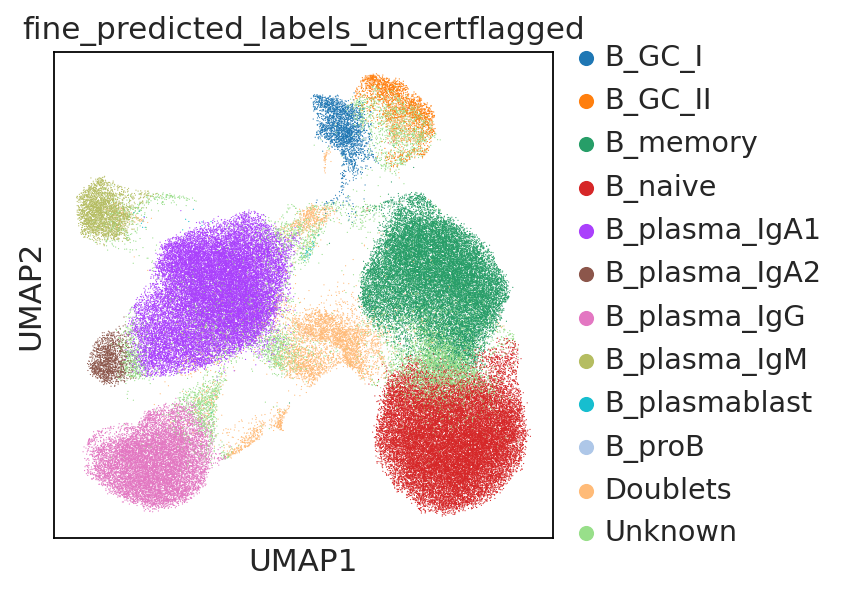

In [30]:
ON = {O:N for O,N in zip(uncert.index,uncert["fine_predicted_labels"])}
adata.obs["fine_predicted_labels_uncertflagged"] = [ON[O] if O in ON else N for O,N in zip(adata.obs_names, adata.obs["fine_predicted_labels_uncertflagged"])]
sc.pl.umap(adata,color='fine_predicted_labels_uncertflagged')

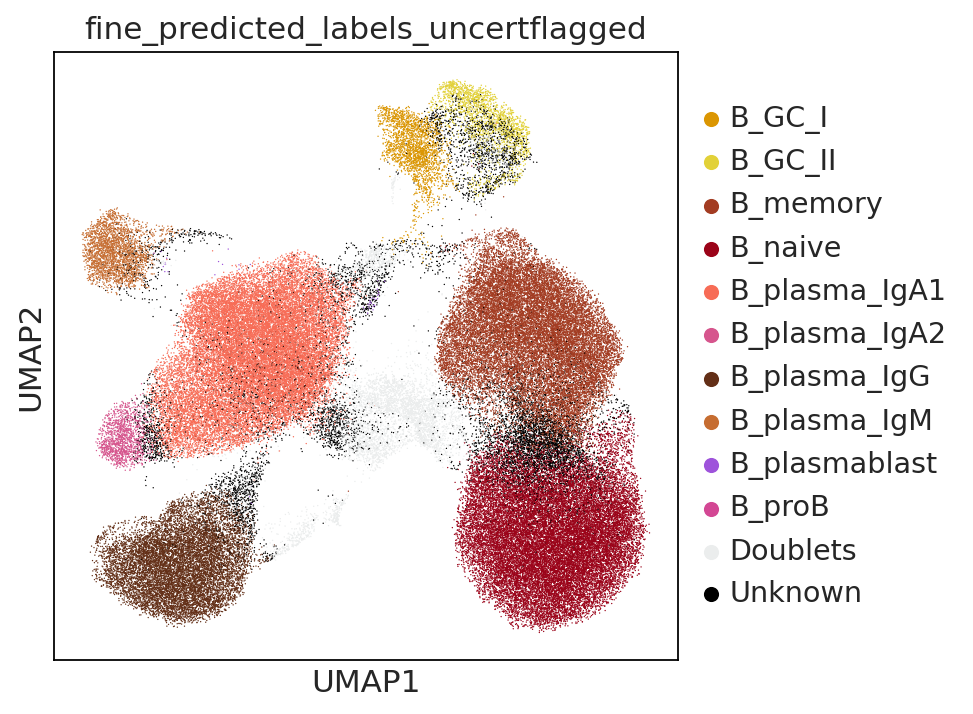

In [31]:
plt.rcParams['figure.figsize'] = [5,5]
sc.pl.umap(adata,color='fine_predicted_labels_uncertflagged',palette = ['#db9602', #B_GC_I
'#e2d138', #B_GC_II
'#a33c22',#B_memory
'#9b0319', #B_naive
'#f76c56',#B_plasma_IgA1
'#d6558d',#B_plasma_IgA2
'#632f17',#B_plasma_IgG                            
'#c66d31',#B_plasma_IgM
'#9e53db',#B_plasmablast
#'#8a4682',#B_preB
'#d34794',#pro b
                                                            '#ebeded',#doublets
                                                                        '#000000'#unknown
                                                       
                                               
                                               
    
    
                                              ],size=1.5,save='B_scanviannot_uncertflagged.pdf')

In [32]:
#reassign labels for unknown cells by leiden clustering and majority voting
sc.tl.leiden(adata,resolution=1,key_added='leiden1')

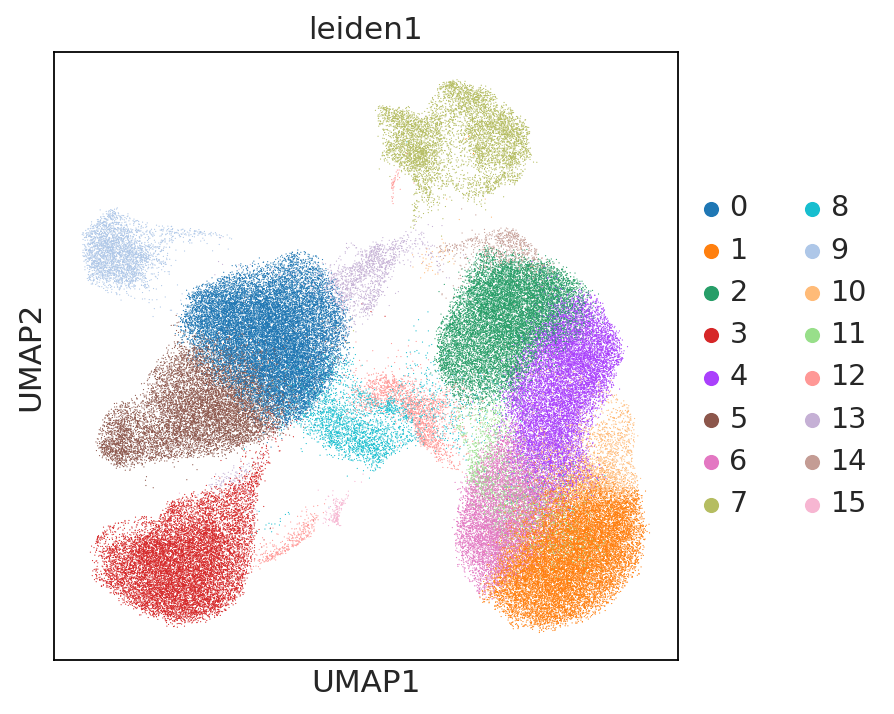

In [33]:
sc.pl.umap(adata,color='leiden1',save='B_scanviannot_leiden.pdf')

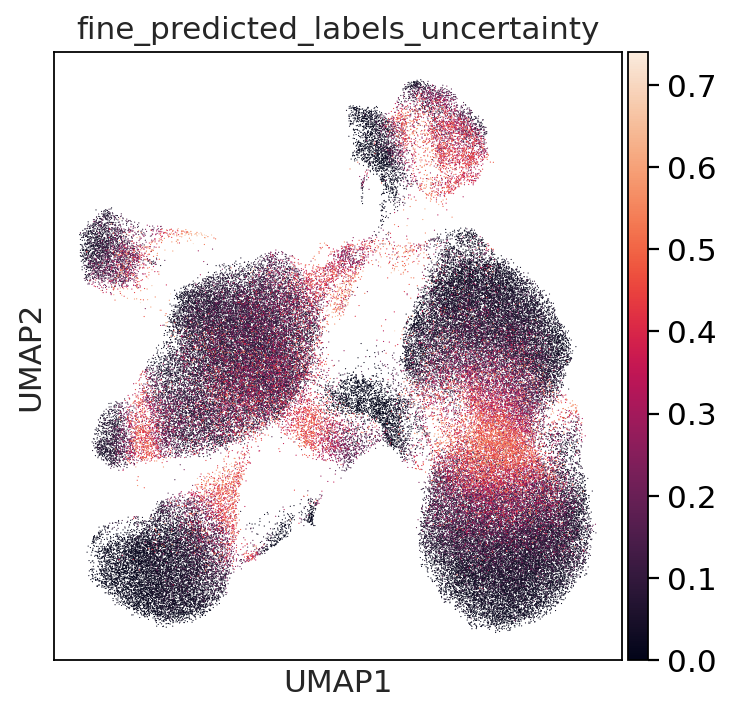

In [34]:
sc.pl.umap(adata,color='fine_predicted_labels_uncertainty',save='B_scanviannot_uncertainty.pdf')

In [35]:
annot = pd.read_csv('/nfs/team205/ao15/Megagut/Annotations_v3/disease_annot/resolved_annot/B_disease_annot.csv',index_col=0)

In [36]:
annot

fine_predicted_labels_uncertflagged  \
index                                                                  
AAACCTGAGAGGTTAT-4918STDY7273964                             B_naive   
AAACGGGAGAGCTGGT-4918STDY7273964                             B_naive   
AAACGGGCACTAAGTC-4918STDY7273964                             B_naive   
AAACGGGGTAAAGGAG-4918STDY7273964                             B_GC_II   
AAACGGGGTAGCGATG-4918STDY7273964                             B_naive   
...                                                              ...   
TTTGCGCGTCTGATTG-GSM4546346                            B_plasma_IgA1   
TTTGCGCTCATTGCCC-GSM4546346                            B_plasma_IgA1   
TTTGGTTGTACCTACA-GSM4546346                             B_plasma_IgG   
TTTGTCATCGGAAACG-GSM4546346                            B_plasma_IgA2   
TTTGTCATCGGATGTT-GSM4546346                             B_plasma_IgG   

                                 fine_predicted_labels_resolved  
index                                                            
AAACCTGAGAGGTTAT-4918STDY7273964                        B_naive  
AAACGGGAGAGCTGGT-4918STDY7273964                        B_naive  
AAACGGGCACTAAGTC-4918STDY7273964                        B_naive  
AAACGGGGTAAAGGAG-4918STDY7273964                        B_GC_II  
AAACGGGGTAGCGATG-4918STDY7273964                        B_naive  
...                                                         ...  
TTTGCGCGTCTGATTG-GSM4546346                       B_plasma_IgA1  
TTTGCGCTCATTGCCC-GSM4546346                       B_plasma_IgA1  
TTTGGTTGTACCTACA-GSM4546346                        B_plasma_IgG  
TTTGTCATCGGAAACG-GSM4546346                       B_plasma_IgA2  
TTTGTCATCGGATGTT-GSM4546346                        B_plasma_IgG  

[106472 rows x 2 columns]

In [37]:
adata.obs['fine_predicted_labels_resolved'] = annot.fine_predicted_labels_resolved

/home/jovyan/my-conda-envs/standard_plotting/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


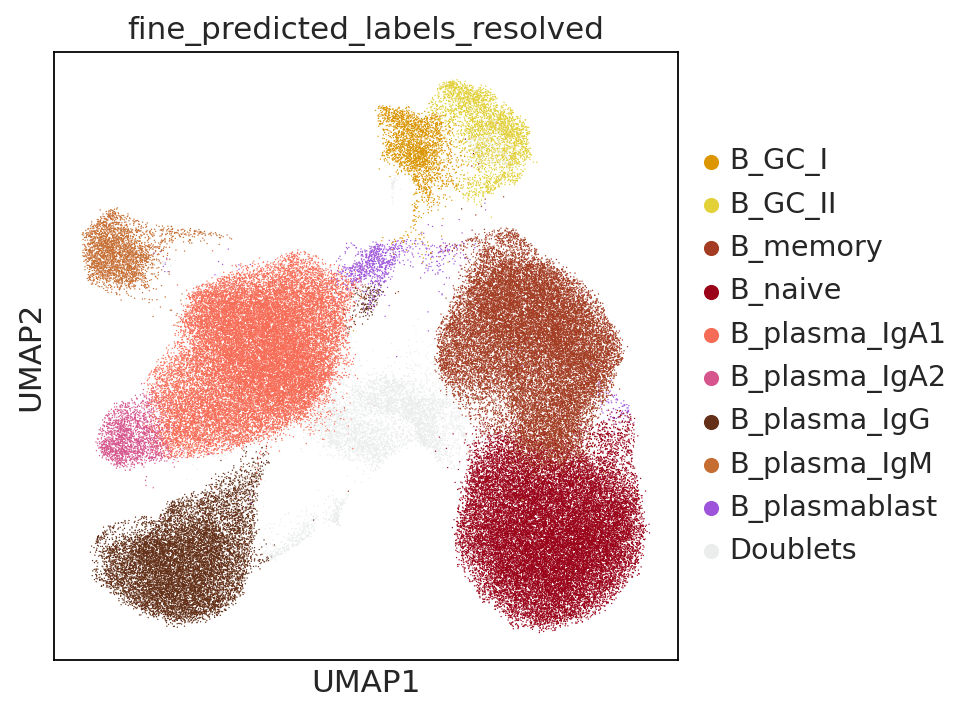

In [38]:
plt.rcParams['figure.figsize'] = [5,5]
sc.pl.umap(adata,color='fine_predicted_labels_resolved',palette = ['#db9602', #B_GC_I
'#e2d138', #B_GC_II
'#a33c22',#B_memory
'#9b0319', #B_naive
'#f76c56',#B_plasma_IgA1
'#d6558d',#B_plasma_IgA2
'#632f17',#B_plasma_IgG                            
'#c66d31',#B_plasma_IgM
'#9e53db',#B_plasmablast
#'#8a4682',#B_preB
#'#d34794',#pro b
                                                            '#ebeded',#doublets
                                                                       
                                                       
                                               
                                               
    
    
                                              ],size=1.5,save='B_scanviannot_labelsresolved.pdf')

/home/jovyan/my-conda-envs/standard_plotting/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


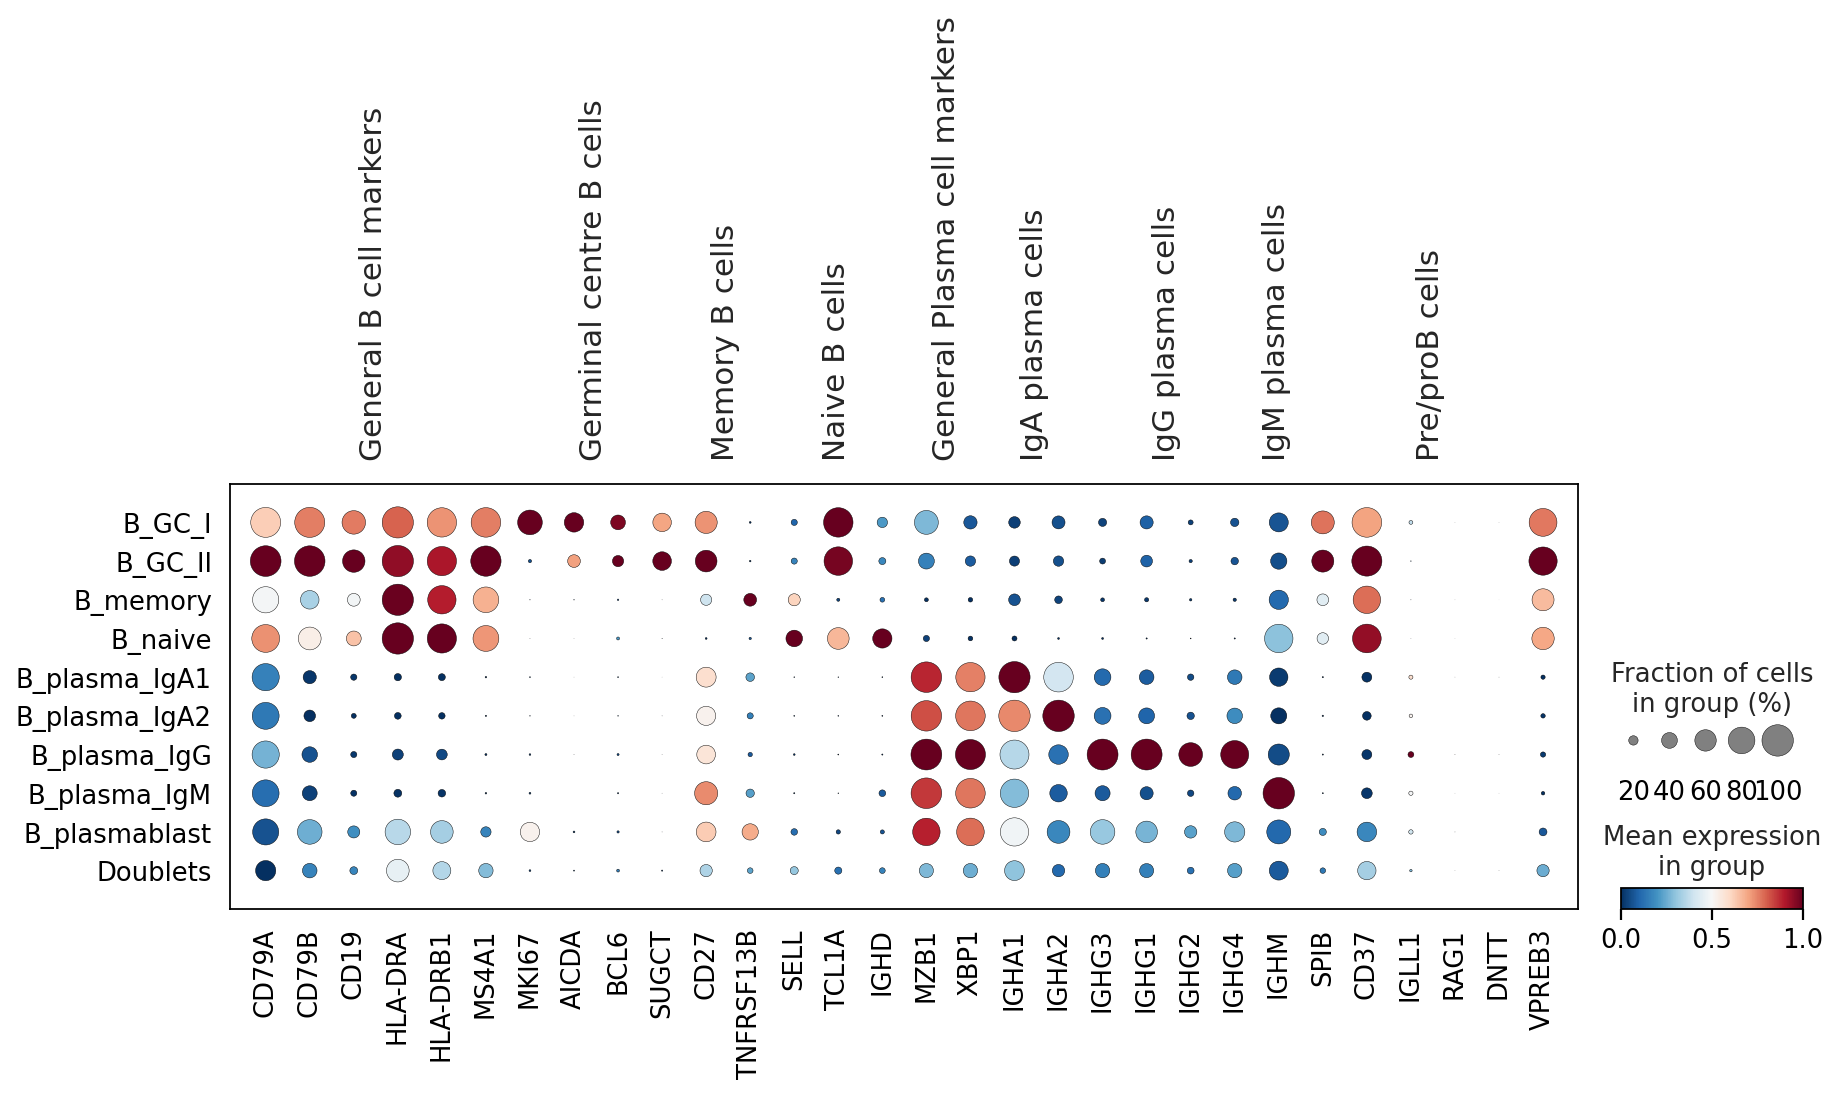

In [39]:
sc.set_figure_params(dpi_save = 300)
sc.pl.dotplot(adata,var_names=marker_genes_dict,groupby='fine_predicted_labels_resolved',color_map='RdBu_r', standard_scale='var',save='B_scanviannot_resvoledmarkers.pdf')

In [40]:
colors={
    'Doublets':'#ebeded',
    'EC_venous': '#2a4858',
  'Mast': '#826e91',
  'EC_capillary': '#855f9a',
  'DC_cDC1': '#8c543f',
  'Monocyte': '#5baf07',
  'DC_cDC2': '#cfdb65',
  'Basal': '#727271',
  'Treg_IL10': '#e5c510',
  'Crypt_fibroblast_PI16': '#bd7879',
  'Macrophage': '#486626',
  'Vascular_smooth_muscle': '#1E4147',
  'Lamina_propria_fibroblast_ADAMDEC1': '#e95e50',
  'Epithelial_cycling_G2M': '#ff3c4b',
  'Keratinocyte_stratified': '#EDD3E0',
  'Trm/em_CD8': '#256b87',
  'Pericyte': '#437356',
  'Oral_mucosa_fibroblast': '#303267',
  'Macrophage_MMP9': '#a5f002',
  'EC_lymphatic': '#999999',
  'Rectum_fibroblast': '#522e25',
  'Trm_Th17': '#1e093f',
  'DC_migratory': '#e6a519',
  'Epithelial_cycling_S': '#ff8433',
  'Trm_CD4': '#8107ed',
  'NK_CD16': '#0c1e0e',
  'Macrophage_LYVE1': '#8fd9d0',
  'Trm_CD8': '#2844c1',
  'Macrophage_TREM2': '#42c7ac',
  'Keratinocyte_inflammatory': '#E0AC9D',
  'Tnaive/cm_CD4': '#9c53bc',
  'DC_pDC': '#bdb197',
  'Villus_fibroblast_F3': '#d64582',
  'EC_arterial_2': '#ca6092',
  'EC_arterial_1': '#fa6e6e',
  'gdT': '#3fafb5',
  'B_memory': '#a33c22',
  'T/NK_cycling': '#c260ff',
  'Immune_recruiting_pericyte': '#AAC789',
  'MAIT': '#21b796',
  'ILC3': '#778c00',
  'Melanocyte': '#886F61',
  'Tfh_naive': '#5e3c55',
  'Keratinocyte_outer': '#BF7A9C',
  'EC_cycling': '#fac06e',
  'Tnaive/cm_CD8': '#5ca4ce',
  'NK_CD56bright': '#3f8c08',
  'B_naive': '#9b0319',
  'B_preB': '#8a4682',
  'Treg': '#f98261',
  'B_proB': '#d34794',
  'B_plasmablast': '#9e53db',
  'B_plasma_IgG': '#632f17',
  'Megakaryocyte/platelet': '#c730aa',
  'TA': '#b85f1c',
  'Mono/neutrophil_MPO': '#2a497a',
  'B_plasma_IgA1': '#f76c56',
  'Macrophage_CD5L': '#caf9cf',
  'Tfh': '#5e0b30',
  'Oesophagus_fibroblast': '#63A0C0',
  'B_plasma_IgA2': '#d6558d',
  'gdT_naive': '#26daf2',
  'B_GC_I': '#db9602',
  'B_plasma_IgM': '#c66d31',
  'DC_langerhans': '#c7a642',
  'Fibroblast_reticular': '#f0c134',
  'B_GC_II': '#e2d138',
  'Follicular_DC': '#f0982c',
  'Microfold': '#e55b85',
  'Enterocyte': '#e1b5e6',
  'Epithelial_stem': '#c924b9',
  'Surface_foveolar': '#d9b74a',
  'Mucous_gland_neck': '#f7b37c',
  'Cycling': '#ff8433',
  'Pareital': '#d45f80',
  'Enteroendocrine_MX': '#292663',
  'Myofibroblast': '#CCAE91',
  'Glial_2': '#0D6986',
  'Enteric_neural_crest_cycling': '#DBA507',
  'Enterochromaffin': '#22517a',
  'Chief': '#c95340',
  'Glial/Enteric_neural_crest': '#a8c545',
  'Enteroendocrine_G': '#2f3f4d',
  'Neuroblast': '#c50637',
  'Goblet_progenitor': '#e9f7ad',
  'Goblet': '#6c9939',
  'Enteroendocrine': '#68b7fc',
  'Erythrocytes': '#0e539c',
  'Enteroendocrine_X': '#7292ad',
  'Glial_3': '#053240',
  'Goblet_cycling': '#d1d14f',
  'BEST4_enterocyte_colonocyte': '#39997c',
  'Tuft': '#9d9dff',
  'Paneth': '#79508f',
  'Serous': '#C9DE55',
  'Mucous': '#67cc8e',
  'Duct': '#7D9100',
  'Seromucous': '#ACEBAE',
  'Myoepithelial': '#572300',
  'Ionocytes': '#9d9dff',
  'Colonocyte': '#d66245',
  'Mature_colonocyte': '#fa6161',
  'Mesoderm_2': '#b4793b',
  'Branch_A_inhibtory_motor_neuron': '#a39bcb',
  'SMC_PPLP2': '#d4d4e8',
  'Cycling_fibroblast': '#d65151',
  'ICC': '#69479b',
  'Branch_B_excitatory_motor_neuron': '#496695',
  'SMC_CAPN3': '#968dc6',
  'Mesoderm_1': '#663818',
  'Branch_B_primary_afferent_neuron': '#909134',
  'Proximal_progenitor_DUO/JEJ': '#fac219',
  'SMC_CAPN3_cycling': '#76738e',
  'Glial_1': '#8EC7D2',
  'Branch_A_primary_afferent_neuron': '#27bdbf',
  'Branch_A_interneuron': '#67608a',
  'NTS': '#baada4',
  'Proximal_progenitor_ILE': '#8f6e0d',
  'Enteroendocrine_progenitor': '#aeebdf',
  'Mesothelium': '#8F6592',
  'Distal_progenitor': '#dbc697',
  'Angiogenic_pericyte': '#308587',
  'Eosinophil/basophil': '#8b4eba',
  'CLDN10': '#706d65',
  'Distal_progenitor_PRAC1': '#8f8161',
  'Immature_pericyte': '#90c496',
  'Mesenchymal_LTO': '#f7eb59',
  'Gastric_fetal_epithelial': '#a01160',
  'DCS_MUC17_cycling': '#99216b',
  'DCS_MUC17': '#9c6b73',
  'Gland_basal': '#404040',
  'Gland_fetal': '#168039',
  'Basal_cycling': '#d1bf82',
  'Keratinocyte_fetal': '#d8306e',
  'Gland_duct': '#7D9100',
  'Gland_mucous': '#67cc8e',
  'Myoblast/myocyte': '#e2798d',
  'Unknown': '#000000'}

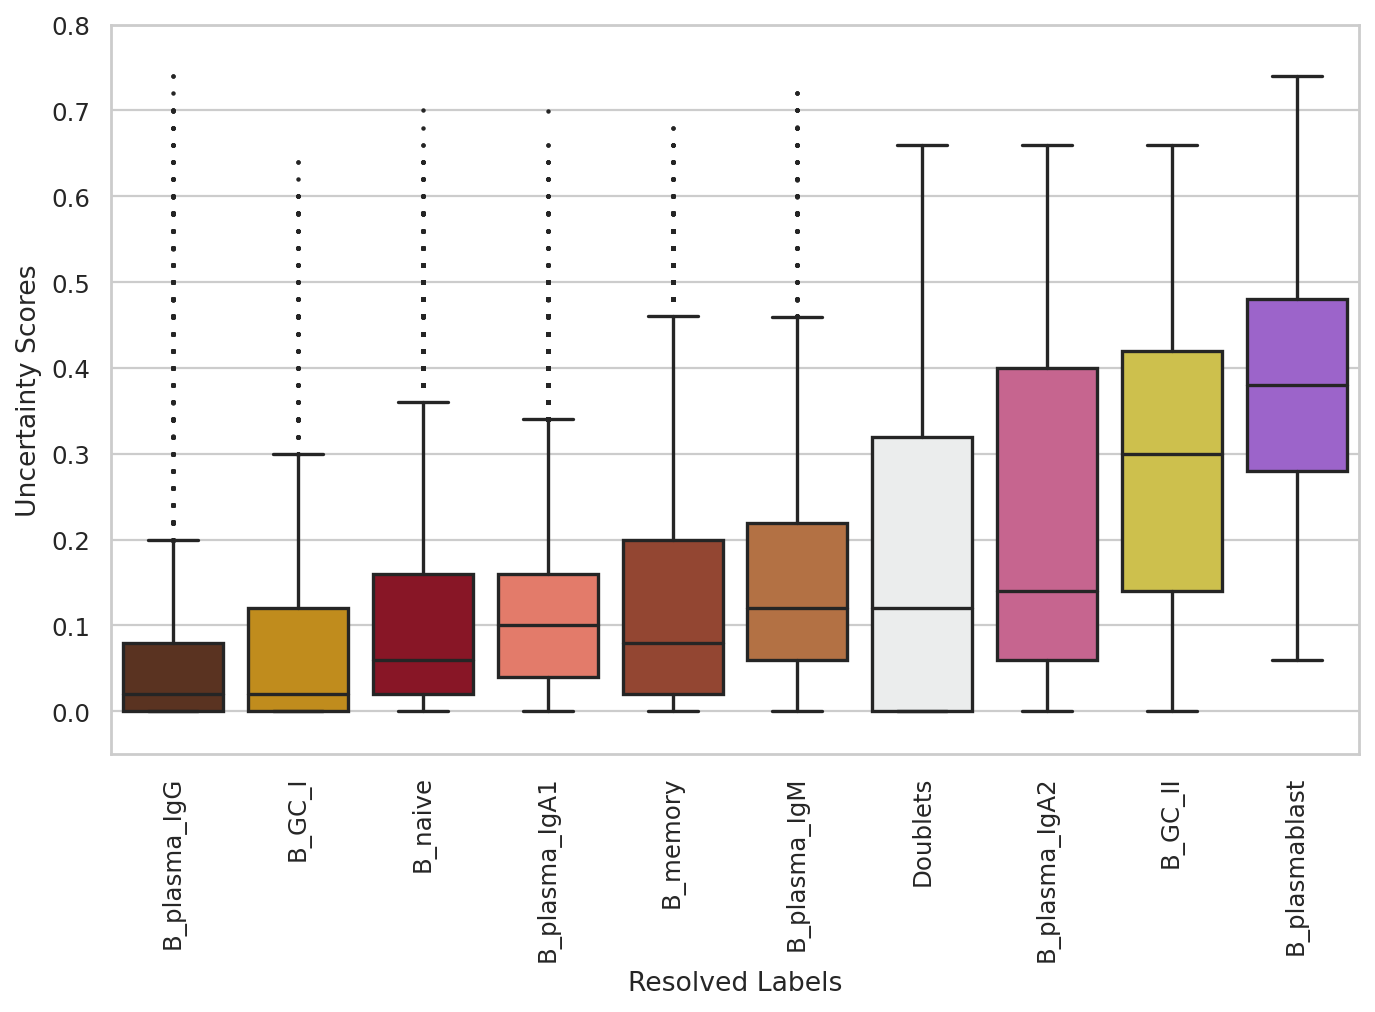

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns  # Optional, but seaborn can enhance the style

# Assuming adata is your AnnData object

# Combine the two variables into a DataFrame for easier plotting
data_to_plot = adata.obs[['fine_predicted_labels_uncertainty', 'fine_predicted_labels_resolved']]

# Use seaborn for better styling (optional)
sns.set(style="whitegrid")

mean_uncertainty = data_to_plot.groupby('fine_predicted_labels_resolved')['fine_predicted_labels_uncertainty'].mean()

# Sort the categories based on mean uncertainty
sorted_categories = mean_uncertainty.sort_values().index

# Create a box and whisker plot
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
ax = sns.boxplot(x='fine_predicted_labels_resolved', y='fine_predicted_labels_uncertainty', 
            data=data_to_plot,palette=colors,order=sorted_categories,flierprops=dict(marker='o', markerfacecolor='gray', markersize=1))

# Add labels and title
plt.xticks(rotation=90)
plt.xlabel('Resolved Labels')
plt.ylabel('Uncertainty Scores')
ax.set_ylim(-0.05, 0.8)

# Save the plot as a PDF file
plt.savefig('B_boxplot_uncertainty_scores.pdf', format='pdf')

# Show the plot
plt.show()

In [42]:
#related to revisions point 2.10 "Have you done differential gene expression analysis of the unknonw cells versus the annotated cells in their cluster?"

In [43]:
adata

AnnData object with n_obs × n_vars = 106472 × 36601
    obs: 'latent_cell_probability', 'latent_RT_efficiency', 'cecilia22_predH', 'cecilia22_predH_prob', 'cecilia22_predH_uncertain', 'cecilia22_predL', 'cecilia22_predL_prob', 'cecilia22_predL_uncertain', 'elmentaite21_pred', 'elmentaite21_pred_prob', 'elmentaite21_pred_uncertain', 'suo22_pred', 'suo22_pred_prob', 'suo22_pred_uncertain', 'n_counts', 'log1p_n_counts', 'n_genes', 'log1p_n_genes', 'percent_mito', 'n_counts_mito', 'percent_ribo', 'n_counts_ribo', 'percent_hb', 'n_counts_hb', 'percent_top50', 'n_counts_raw', 'log1p_n_counts_raw', 'n_genes_raw', 'log1p_n_genes_raw', 'percent_mito_raw', 'n_counts_mito_raw', 'percent_ribo_raw', 'n_counts_ribo_raw', 'percent_hb_raw', 'n_counts_hb_raw', 'percent_top50_raw', 'n_counts_spliced', 'log1p_n_counts_spliced', 'n_genes_spliced', 'log1p_n_genes_spliced', 'percent_mito_spliced', 'n_counts_mito_spliced', 'percent_ribo_spliced', 'n_counts_ribo_spliced', 'percent_hb_spliced', 'n_counts_hb_sp

In [44]:
adata.obs['unknown_clusterlabel'] = adata.obs['fine_predicted_labels_uncertflagged'].astype(str) + '_' + adata.obs['fine_predicted_labels_resolved'].astype(str)

In [45]:
adata.obs['unknown_clusterlabel'].value_counts()

B_naive_B_naive                25932
B_plasma_IgA1_B_plasma_IgA1    24844
B_memory_B_memory              21053
B_plasma_IgG_B_plasma_IgG      11105
Doublets_Doublets               4782
Unknown_B_memory                2730
B_plasma_IgM_B_plasma_IgM       2510
B_GC_I_B_GC_I                   2257
B_GC_II_B_GC_II                 1942
Unknown_B_naive                 1815
B_plasma_IgA2_B_plasma_IgA2     1385
Unknown_B_plasma_IgA1           1198
Unknown_B_GC_II                  992
Unknown_B_plasma_IgG             991
Unknown_Doublets                 833
Unknown_B_plasma_IgA2            526
Unknown_B_plasmablast            501
Doublets_B_plasmablast           470
Unknown_B_plasma_IgM             333
Unknown_B_GC_I                   223
B_plasmablast_B_plasmablast       49
B_proB_B_plasma_IgA1               1
Name: unknown_clusterlabel, dtype: int64

In [46]:
adata.X.max()

9.079593

In [48]:
adata_compare = adata[~adata.obs.unknown_clusterlabel.isin(['B_proB_B_plasma_IgA1'])].copy()

/home/jovyan/my-conda-envs/standard_plotting/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/home/jovyan/my-conda-envs/standard_plotting/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
/home/jovyan/my-conda-envs/standard_plotting/lib/python3.8/site-packages/scanpy/tools/_rank

         Falling back to preprocessing with `sc.pp.pca` and default params.


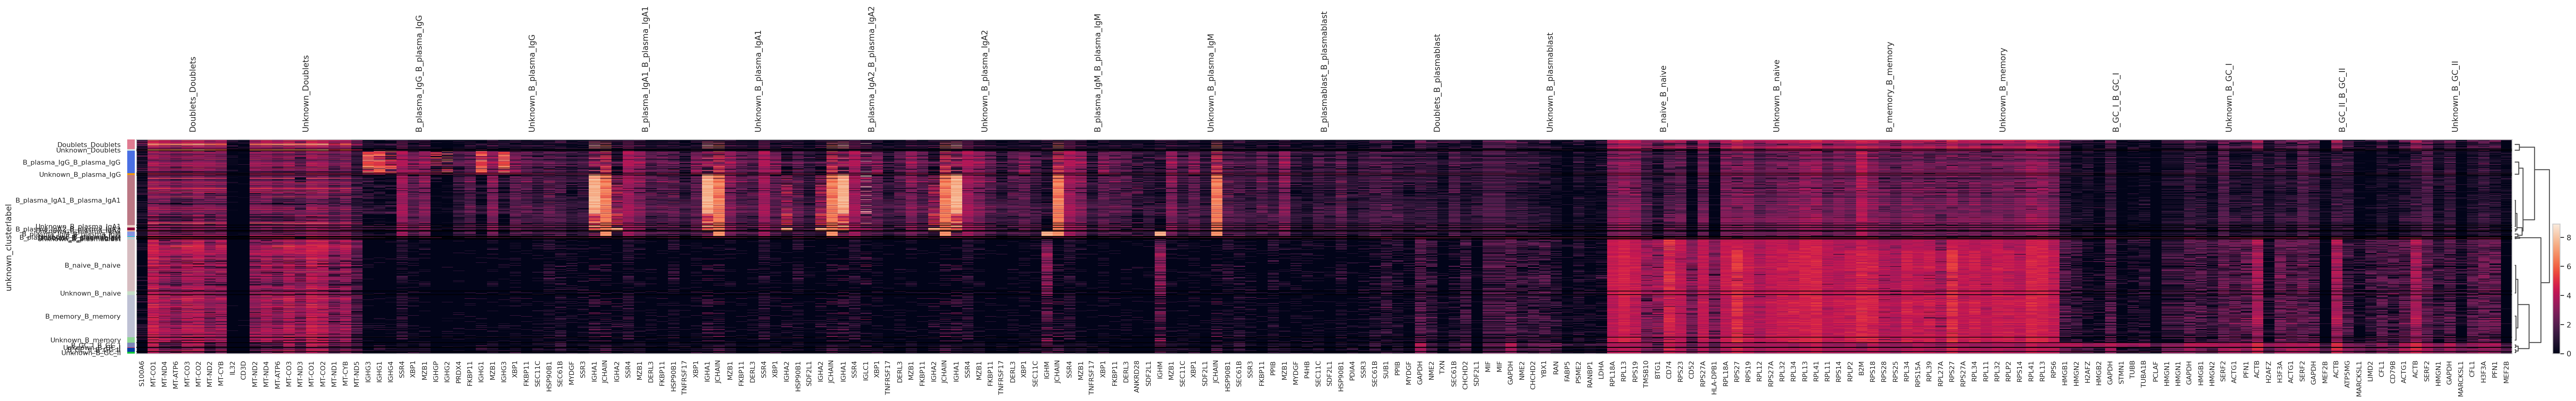

In [49]:
sc.tl.rank_genes_groups(adata_compare, 'unknown_clusterlabel', method='wilcoxon')
sc.pl.rank_genes_groups_heatmap(adata_compare, show_gene_labels=True)

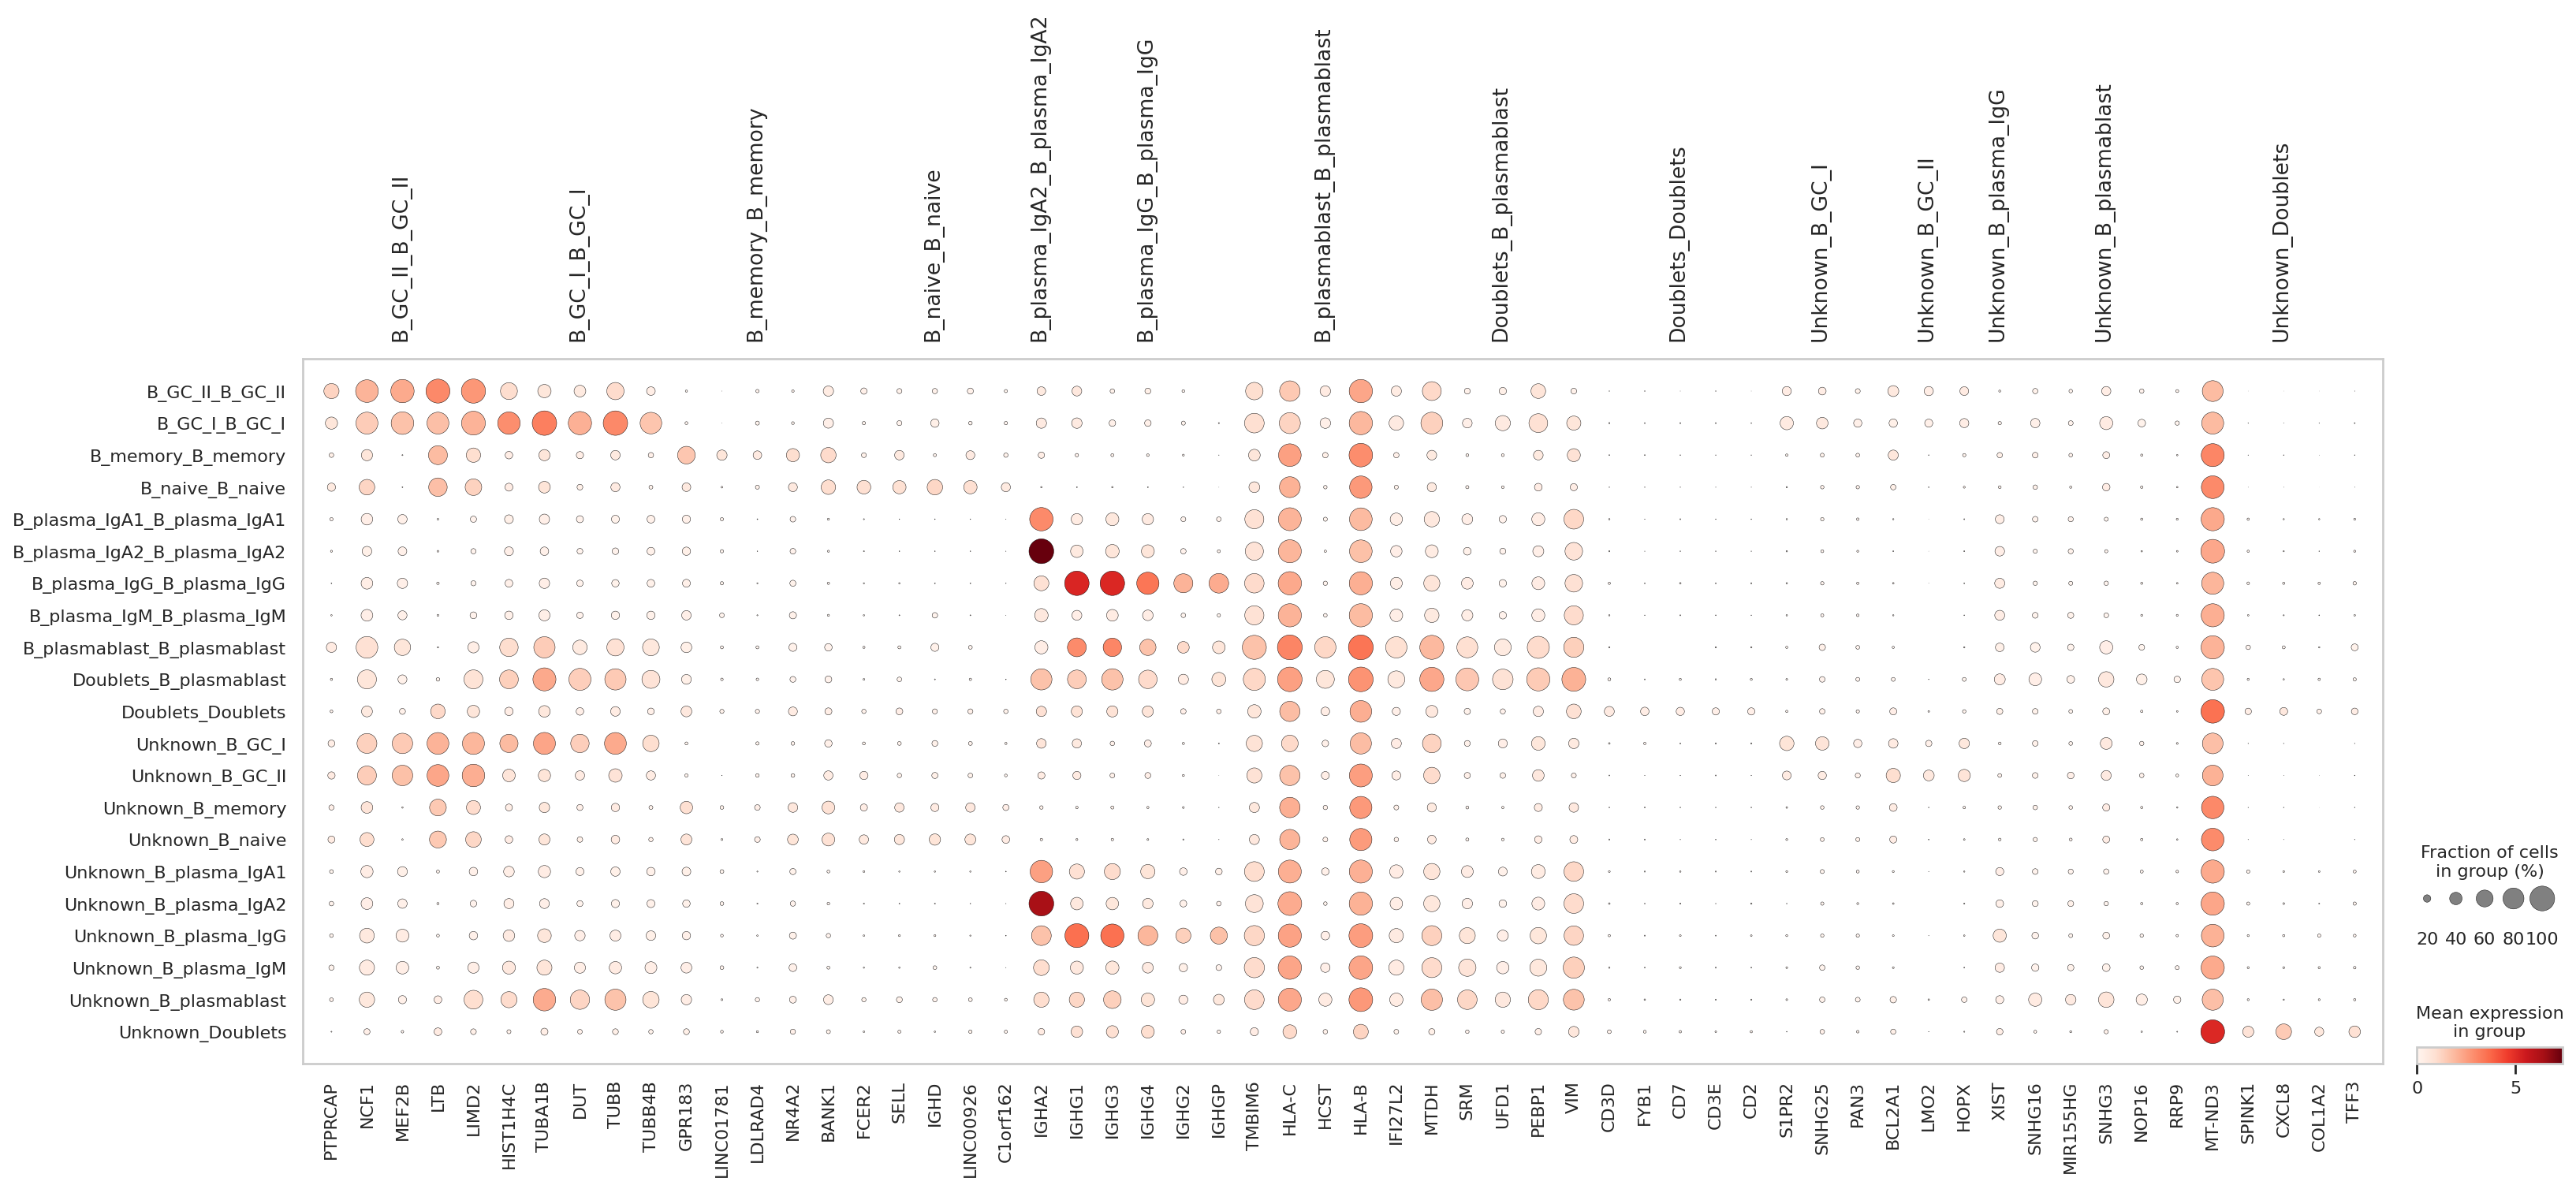

In [51]:
import sys
sys.path.append("/home/jovyan/ao15/Megagut/")
from re5_combine import *
adata_compare.raw = adata_compare.copy()
mkst = calc_marker_stats(adata_compare, groupby="unknown_clusterlabel")
mks = filter_marker_stats(mkst[2], min_frac_diff=0.1, min_mean_diff=0.1, max_next_frac=0.5, max_next_mean=0.95, strict=False, how='or')
plot_markers(adata_compare, groupby='unknown_clusterlabel', mks=mks)

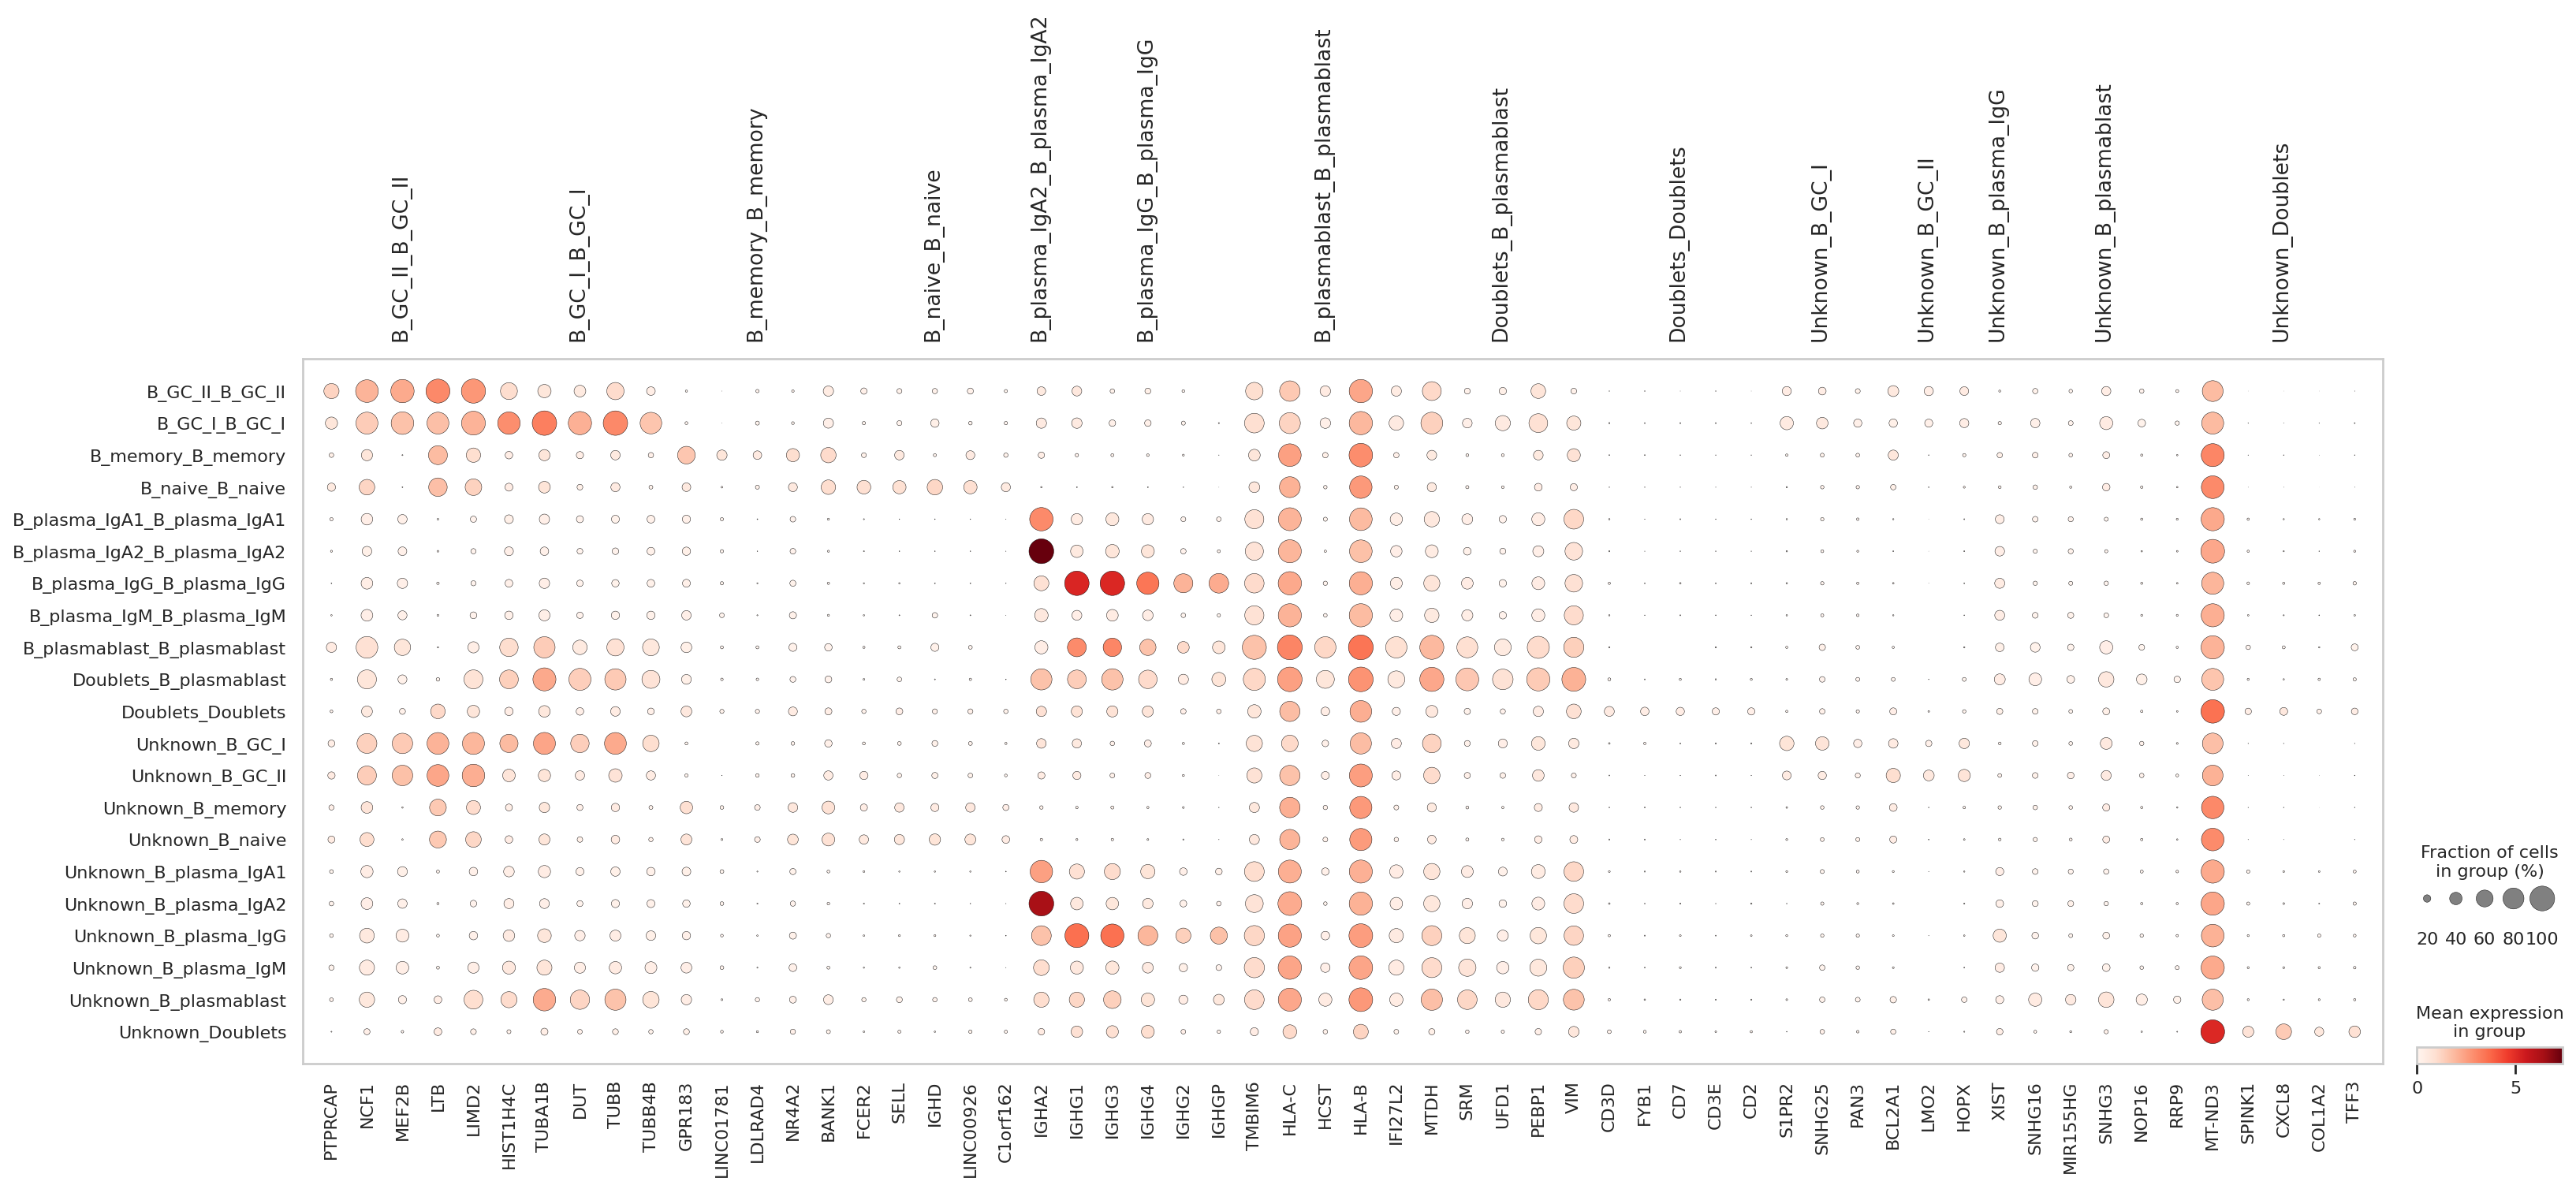

In [52]:
plot_markers(adata_compare, groupby='unknown_clusterlabel', mks=mks,save='B_unknown_specificDGE.pdf')